In [1]:
from ast import literal_eval
from glob import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import XML2Dict

In [4]:
%matplotlib notebook

Save location

In [5]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\respiration'

## Load EEG experiment

In [6]:
recfolder = r'E:\respiration_testing\mouse689239\thermistor_aw_iso_2023-07-14_11-41-50\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

No *stim* files were found.
Experiment type: spontaneous
thermistor_aw_iso


### Load respiration, running, and iso data

In [7]:
respiration, respiration_ts = exp.load_analog_respiration()
running, running_ts = exp.load_running()
iso, iso_ts = exp.load_analog_iso()

#### Plot all signals

<IPython.core.display.Javascript object>


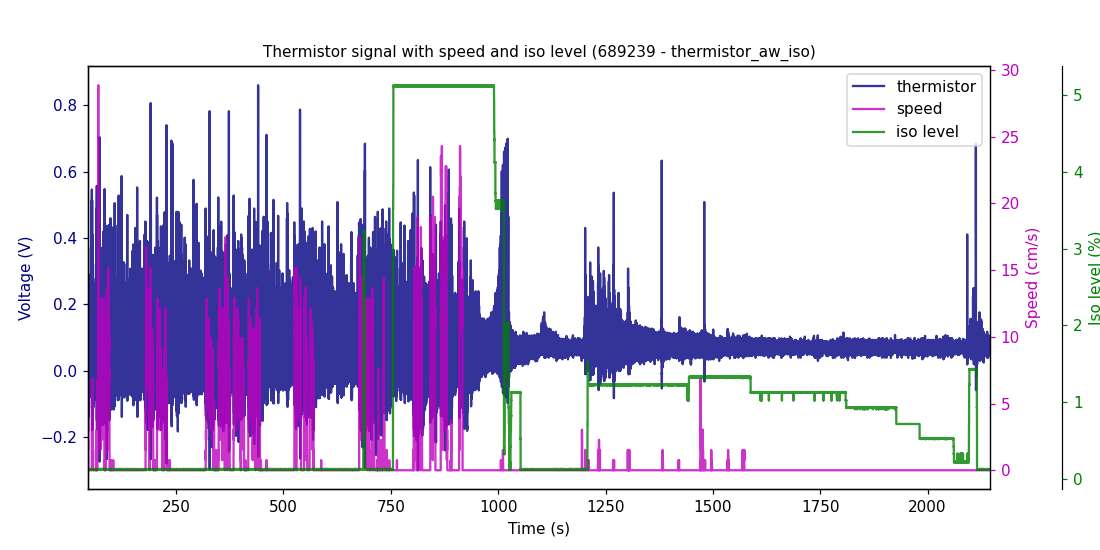

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.subplots_adjust(left=0.08, right=0.9)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.08))

p1, = ax.plot(respiration_ts, respiration, color='navy', alpha=0.8, label='thermistor')
p2, = twin1.plot(running_ts, running, color='m', alpha=0.8, label='speed')
p3, = twin2.plot(iso_ts, iso, color='g', alpha=0.8, label='iso level')

ax.set(xlim=(respiration_ts[0], respiration_ts[-1]), xlabel="Time (s)", ylabel="Voltage (V)")
twin1.set(ylabel="Speed (cm/s)")
twin2.set(ylabel="Iso level (%)")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())

ax.legend(handles=[p1, p2, p3], loc='upper right')
ax.set_title('Thermistor signal with speed and iso level ({} - {})'.format(exp.mouse, exp_tag))

## Save ##
figname = 'thermistor_speed_iso_wholerec_{}_{}.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Spectral analysis of raw thermistor signal

In [9]:
frex, Pxx_resp = signal.welch(
    respiration, exp.ephys_params['EEG']['sample_rate'], nperseg=4 * exp.ephys_params['EEG']['sample_rate'], axis=0
)
print(len(frex))

5001


<IPython.core.display.Javascript object>


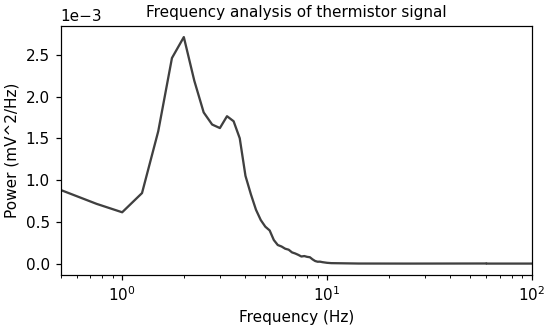

In [10]:
fthresh = 100 # frequency threshold for plotting
frinds = frex < fthresh

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
ax.semilogx(frex[frinds], Pxx_resp[frinds], color='k', linewidth=1.5, alpha=0.75)
ax.set_xlim([0.5, fthresh])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Frequency analysis of thermistor signal')

## Save ##
figname = 'thermistor_spectrum_{}_{}.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Apply a bandpass filter to raw thermistor signal

In [11]:
freqs = [0.5, 25]
bpb, bpa = signal.butter(3, np.array(freqs)/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_resp = signal.filtfilt(bpb, bpa, respiration)

<IPython.core.display.Javascript object>


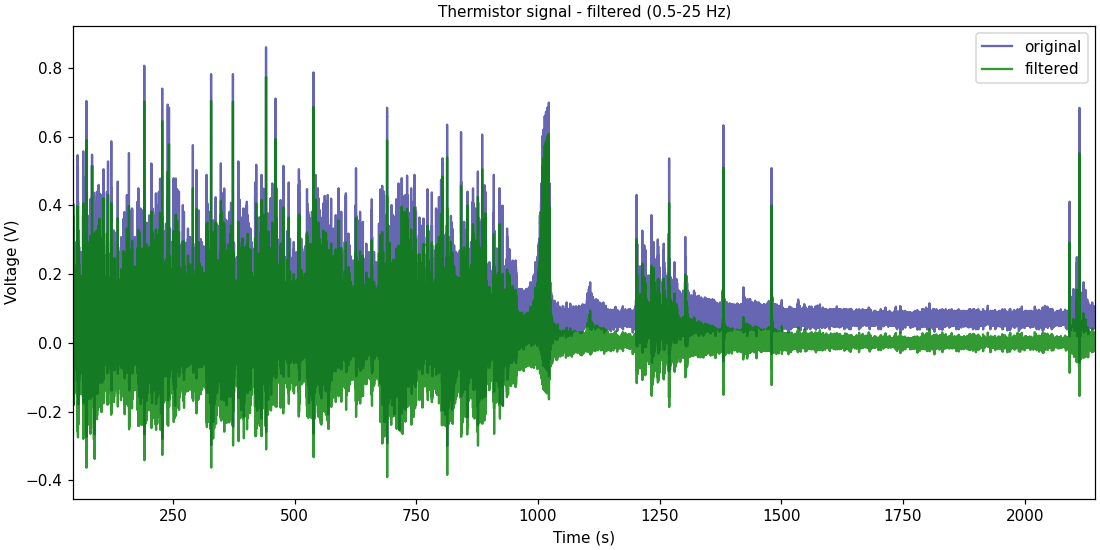

In [12]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
plot_win = [respiration_ts[0], respiration_ts[-1]] # plot whole session
# plot_win = [1700, 1730] # plot part of session, seconds

ax.plot(respiration_ts, respiration, color='navy', alpha=0.6, label='original')
ax.plot(respiration_ts, filt_resp, color='g', alpha=0.8, label='filtered')

ax.set_xlim(plot_win)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Thermistor signal - filtered ({:.1f}-{:d} Hz)'.format(freqs[0], freqs[1]))
ax.legend()

## Save ##
figname = 'thermistor_filtered_{}_{}.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Inhalation and exhalation
According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4801653/ (figure 2), inhalation/inspiration begins at the trough of the thermistor signal and continues to the peak (the thermistor is cooling); exhalation/expiration is the peak-trough time.
<br> Also, Lydia tested in the lab and confirmed the polarity does not change depending on which way the cable is plugged in.

<IPython.core.display.Javascript object>


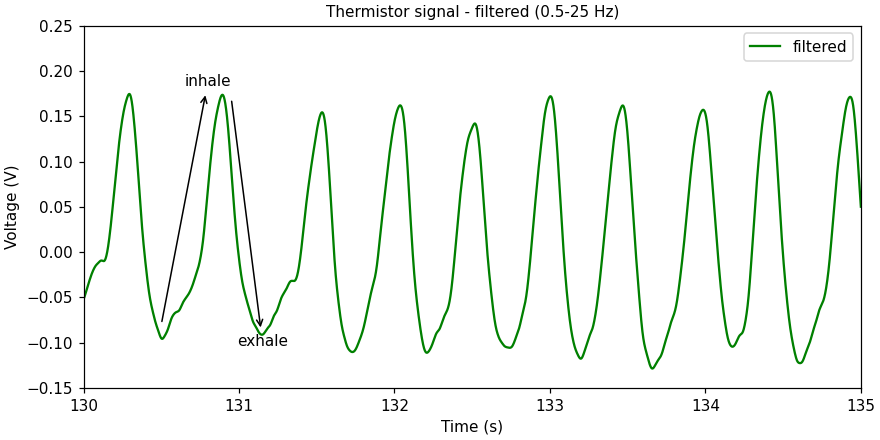

In [28]:
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
plot_win = [130, 135] # plot part of session, seconds

ax.plot(respiration_ts, filt_resp, color='g', label='filtered')

ax.set_xlim(plot_win)
ax.set_ylim([-0.15, 0.25])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Thermistor signal - filtered ({:.1f}-{:d} Hz)'.format(freqs[0], freqs[1]))
ax.legend()

## Annotate ##
ax.annotate(
    'inhale', xy=(130.5, -0.08), xycoords='data', xytext=(130.8, 0.18), textcoords='data',
    arrowprops=dict(arrowstyle='<-'), ha='center', va='bottom'
)
ax.annotate(
    'exhale', xy=(130.95, 0.17), xycoords='data', xytext=(131.15, -0.09), textcoords='data',
    arrowprops=dict(arrowstyle='<-'), ha='center', va='top'
)

## Save ##
figname = 'inh_exh_polarity_{}_{}.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

#### Plot filtered signal with iso signal

### Get respiration rate

This uses scipy.signal.find_peaks() then bins the peaks and applies a gaussian smoothing to get a smoothed respiration rate (Hz). It seems to work well when the mouse is awake, but has failed during deep isoflurane anesthesia (when the thermistor signal has a very low amplitude).
<br>Could also see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4801653/ for analysis techniques.

In [53]:
resp_pks, rpksinfo = signal.find_peaks(filt_resp, height=-0.03, distance=200)

In [54]:
time_bin = 0.05 # size of time bins (s)
sigma = 10

bins = np.arange(respiration_ts[0], respiration_ts[-1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

pkcounts, edges = np.histogram(respiration_ts[resp_pks], bins)
resp_rate = (ndimage.gaussian_filter(pkcounts, sigma=sigma, output=float) / (time_bin))

#### Plot respiration rate and the mouse's speed

<IPython.core.display.Javascript object>


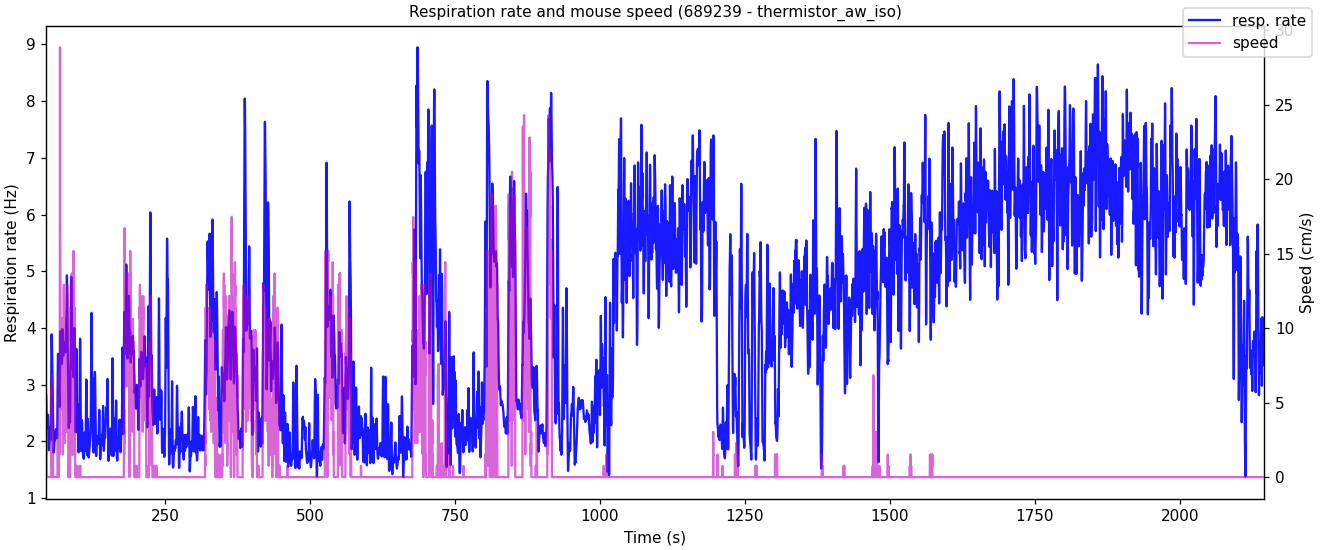

In [57]:
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

ax1 = ax.twinx()
ax1.plot(running_ts, running, color='m', alpha=0.6, label='speed')
ax.plot(timex, resp_rate, color='b', alpha=0.9, label='resp. rate')

ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Respiration rate (Hz)')
ax1.set_ylabel('Speed (cm/s)')
ax.set_title('Respiration rate and mouse speed ({} - {})'.format(exp.mouse, exp_tag))
fig.legend()

## Save ##
figname = 'RR_speed_{}_{}.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

#### Plot respiration rate and the filtered thermistor signal

<IPython.core.display.Javascript object>


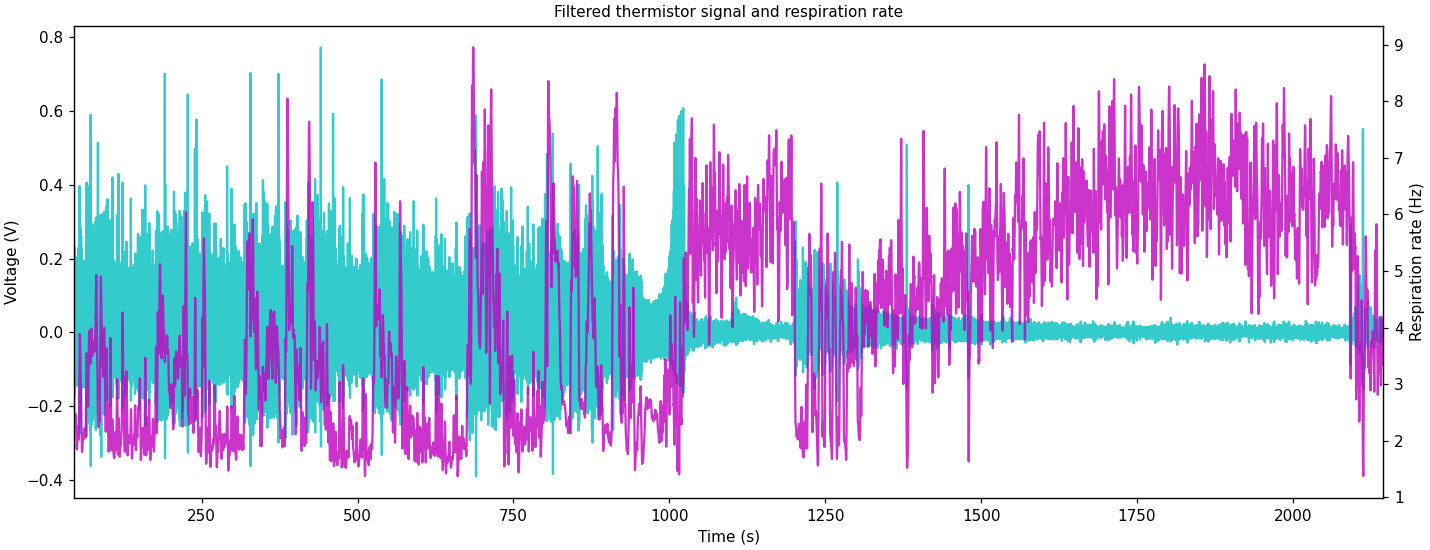

In [56]:
fig, ax = plt.subplots(figsize=(13,5), constrained_layout=True)

ax.plot(respiration_ts, filt_resp, color='c', alpha=0.8, label='thermistor')
ax1 = ax.twinx()
ax1.plot(timex, resp_rate, color='m', alpha=0.8, label='resp. rate')

ax.set_xlim([respiration_ts[0], respiration_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax1.set_ylabel('Respiration rate (Hz)')
ax.set_title('Filtered thermistor signal and respiration rate')

## Save ##
figname = 'thermistor_RR_{}_{}.png'.format(exp.mouse, exp_tag)
fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### TESTING: Find peaks to get respiration rate?

<IPython.core.display.Javascript object>


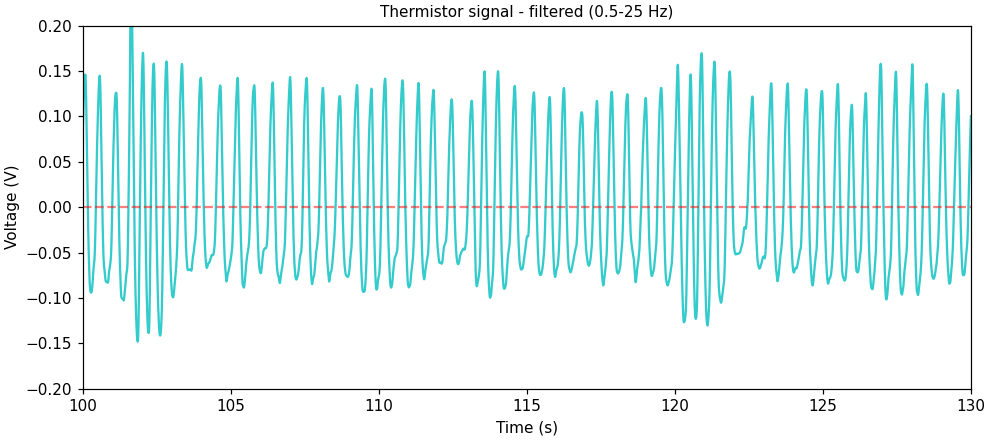

Text(0.5, 1.0, 'Thermistor signal - filtered (0.5-25 Hz)')

In [18]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)
time_win = [100, 130]

ax.plot(respiration_ts, filt_resp, color='c', alpha=0.8, label='filtered')
ax.axhline(0, color='r', linestyle='dashed', alpha=0.5)
ax.set_xlim(time_win)
ax.set_ylim([-0.2, 0.2])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Thermistor signal - filtered ({:.1f}-{:d} Hz)'.format(freqs[0], freqs[1]))

Find peaks above 0 V, probably not perfect, but gets most peaks

In [50]:
peaks, pkinfo = signal.find_peaks(filt_resp, height=0)
print(len(peaks))

7767


Find peaks more than 250 samples apart. Seems to work well if you use height and distance.

In [60]:
peaks2, pk2info = signal.find_peaks(filt_resp, height=0, distance=200)
print(len(peaks2))

6776


In [61]:
pk2info['peak_heights']

array([0.40442878, 0.22861962, 0.21855204, ..., 0.02429482, 0.01362294,
       0.03066118])

<IPython.core.display.Javascript object>


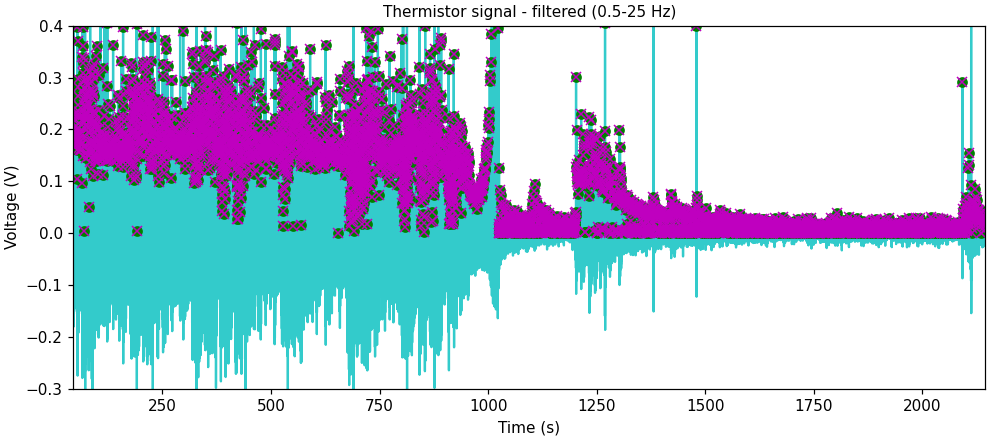

Text(0.5, 1.0, 'Thermistor signal - filtered (0.5-25 Hz)')

In [62]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)
time_win = [respiration_ts[0], respiration_ts[-1]]
# time_win = [100, 200]

ax.plot(respiration_ts, filt_resp, color='c', alpha=0.8, label='filtered')
ax.plot(respiration_ts[peaks], filt_resp[peaks], color='g', marker='o', linestyle='none')
ax.plot(respiration_ts[peaks2], filt_resp[peaks2], color='m', marker='x', linestyle='none')

ax.set_xlim(time_win)
ax.set_ylim([-0.3, 0.4])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Thermistor signal - filtered ({:.1f}-{:d} Hz)'.format(freqs[0], freqs[1]))

### Looking for other analog signals

In [12]:
pressure, pressure_ts = exp.load_OpenEphys_analog_ch(analog_ch_ind=3)

# thermocouple, thermocouple_ts = exp.load_OpenEphys_analog_ch(analog_ch_ind=4)

<IPython.core.display.Javascript object>


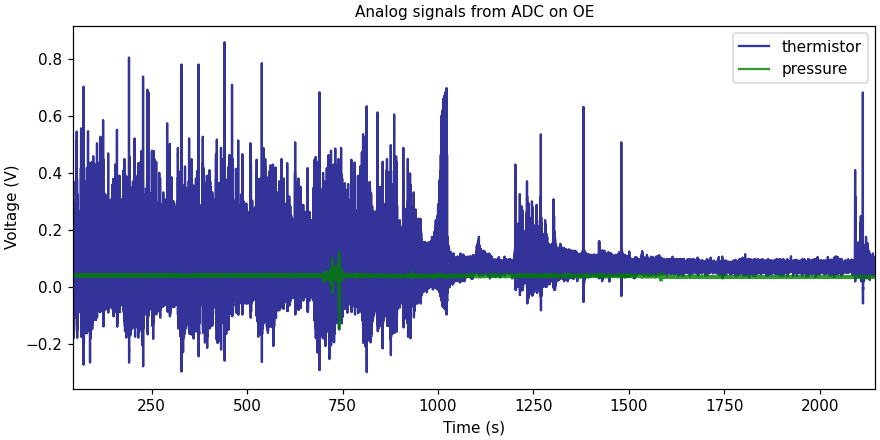

In [13]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

ax.plot(respiration_ts, respiration, color='navy', alpha=0.8, label='thermistor')
ax.plot(pressure_ts, pressure-1, color='g', alpha=0.8, label='pressure')
# ax.plot(thermocouple_ts, thermocouple, color='m', alpha=0.8, label='thermocouple')

ax.set_xlim([respiration_ts[0], respiration_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Analog signals from ADC on OE')
ax.legend()